# Artificial Intelligence Nanodegree Project

## Intelligent Dog breed classification using Convolutional Neural Networks

The approach to the solution(used in Step 6) can be summarized as follows :

1. Train a transfer learning based Human detector. I have used InceptionResNetV2 for generating bottleneck features and have used the dog images provided as part of the project as negative samples for training a binary classifier. Compare performance with HAAR based classifier and use the best one.
2. Use InceptionResNetV2 trained on imagenet data for detecting dogs and compare with resnet50. Use the best one.
3. Check if a dog is detected. 
4. Check if a human is detected.
5. Use Inceptionv3 to clssify dog breed.
5. Change greeting message according to the detected entity.


## Steps in the Notebook

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Import dog as well as human dataset as part of this step. As I'm training two classifiers(Human detector & Dog breed classifier) as part of this approach I will generate an aditional train,test and validation set for training human detector. 

#### Data for training dog breed classifer
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images of dogs
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels


#### Data for training a human detector
- `train_files_hc`, `valid_files_hc`, `test_files_hc` - numpy arrays containing file paths to images for dogs and humans
- `train_targets_hc`, `valid_targets_hc`, `test_targets_hc` - numpy arrays containing 1 for all human images and 0 for everything else 

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import random

#intialize random seed for reproducibility
random.seed(141289)

# define function to load train, test, and validation datasets for dog data
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# define function for splitting a list based on a %age of records
def split_data(data, split=0.8):
    random.shuffle(data)
    return data[:int(split*len(data))],data[int(split*len(data)):]

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.\n'% len(test_files))


# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*")).tolist()
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.

There are 13233 total human images.


#### Now I will generate training ,test and validation data for use in our human detector

In [2]:
# slice human dataset and generate train,test and validation sets
train_files_hc,test_files_hc=split_data(human_files)
test_files_hc,valid_files_hc=split_data(test_files_hc,0.5)

# Generate labels and combine dog and human data for use in training human detector. All dog images are negative samples.
train_targets_hc=[1]*len(train_files_hc)
train_targets_hc.extend([0]*len(train_files))
train_files_hc.extend(train_files)

test_targets_hc=[1]*len(test_files_hc)
test_targets_hc.extend([0]*len(test_files))
test_files_hc.extend(test_files)

valid_targets_hc=[1]*len(valid_files_hc)
valid_targets_hc.extend([0]*len(valid_files))
valid_files_hc.extend(valid_files)

# print statistics about the dataset we created for human detection
print('There are %d positive samples in training data for human detector.' % train_targets_hc.count(1))
print('There are %d negative samples in training data for human detector.' % train_targets_hc.count(0))
print('There are %d total training samples for human detector.\n' % len(train_files_hc))
print('There are %d positive samples in training data for human detector.' % valid_targets_hc.count(1))
print('There are %d negative samples in training data for human detector.' % valid_targets_hc.count(0))
print('There are %d total validation samples for human detector.\n' % len(valid_files_hc))
print('There are %d positive samples in training data for human detector.' % test_targets_hc.count(1))
print('There are %d negative samples in training data for human detector.' % test_targets_hc.count(0))
print('There are %d total test samples for human detector.\n'% len(test_files_hc))

There are 10586 positive samples in training data for human detector.
There are 6680 negative samples in training data for human detector.
There are 17266 total training samples for human detector.

There are 1324 positive samples in training data for human detector.
There are 835 negative samples in training data for human detector.
There are 2159 total validation samples for human detector.

There are 1323 positive samples in training data for human detector.
There are 836 negative samples in training data for human detector.
There are 2159 total test samples for human detector.



---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 2


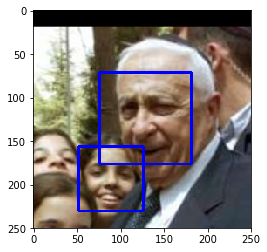

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- 98%
- 12%

False positives are high when using HAAR based detector

In [10]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
face_in_humans=0
face_in_dogs=0
for i in range(100):
    if face_detector(human_files_short[i]):
        face_in_humans+=1
    if face_detector(dog_files_short[i]):
        face_in_dogs+=1
print("Accuracy in human subsample : "+str(face_in_humans/len(human_files_short)))
print("Incorrect classificaton in dog subsample : "+str(face_in_dogs/len(dog_files_short)))

Accuracy in human subsample : 0.98
Incorrect classificaton in dog subsample : 0.12


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

#### Train a human detector using transfer learning and the dataset created earlier 
I will use InceptionResNetV2 imagenet weights to generate bottleneck features. 

A method `bottleneck_features_from_paths` has been added to overcome memory limitations. The method prevents having very large numpy arrays in the memory and only keeps the transformed features. This is very slow(about 20 times slower) but it prevents memory issues.

In [5]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

# From the pretrained models in cv2 HAAR is much more accuracte than LBP so no point in trying LBP. 
# HOG could perform better but so could a CNN.

# New approach to use transfer learning to build a binary classifier to detect presence of human face in an image.
from tqdm import tqdm
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inrv2
from keras.preprocessing import image                  
from PIL import ImageFile      
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

pretrained_model=InceptionResNetV2(weights='imagenet', include_top=False,input_shape=(299,299,3),pooling="avg")

# function to convert an image into a 4d tensor which we need for generating bottleneck features    
def path_to_tensor_inv4(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(299, 299))
    # convert PIL.Image.Image type to 3D tensor with shape (299, 299, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 299, 299, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

# function to generate and save bottleneck features for use in building a transfer learning based binary classifier
def bottleneck_features_from_paths(img_paths):    
    list_of_features = [pretrained_model.predict(preprocess_inrv2(path_to_tensor_inv4(img_path).astype('float32')/255)) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_features)

# function to generate and save bottleneck features for a single image
def bottleneck_features_from_path(img_path):
    return pretrained_model.predict(preprocess_inrv2(path_to_tensor_inv4(img_path).astype('float32')/255))



In [8]:
#save bottleneck features

np.save(open('./bottleneck_features/bottleneck_features_train_hc.npy', 'wb'), bottleneck_features_from_paths(train_files_hc))
np.save(open('./bottleneck_features/bottleneck_features_valid_hc.npy', 'wb'), bottleneck_features_from_paths(valid_files_hc))
np.save(open('./bottleneck_features/bottleneck_features_test_hc.npy', 'wb'), bottleneck_features_from_paths(test_files_hc))


100%|██████████████████████████████████████████████████████████████████████████████| 2159/2159 [02:49<00:00, 12.74it/s]


**Now that bottleneck features are generated I will define neural net architecture**

In [6]:
from keras.models import Model
from keras.layers import Dense, Dropout,LeakyReLU,Input

# load saved bottleneck features
train_inp_hc=np.load('./bottleneck_features/bottleneck_features_train_hc.npy')
test_inp_hc=np.load('./bottleneck_features/bottleneck_features_test_hc.npy')
valid_inp_hc=np.load('./bottleneck_features/bottleneck_features_valid_hc.npy')

# neural net architecture
inp = Input(shape=train_inp_hc.shape[1:])
hid = Dense(1000, activation='linear')(inp)
hid = LeakyReLU()(hid)
hid = Dropout(0.3)(hid)
opt = Dense(1, activation='sigmoid')(hid)

human_detector_model = Model(inputs=inp, outputs=opt)
human_detector_model.compile(optimizer='nadam', loss='binary_crossentropy',metrics=['accuracy'])

human_detector_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1537000   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 1,538,001
Trainable params: 1,538,001
Non-trainable params: 0
_________________________________________________________________


**Declare callbacks and train the model for 100 epochs**

In [10]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='./saved_models/human_detector_InV4.hdf5',verbose=1, save_best_only=True)

epochs = 100
batch_size = 32

human_detector_model.fit(train_inp_hc, train_targets_hc, validation_data=(valid_inp_hc, valid_targets_hc),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=2)



Train on 17266 samples, validate on 2159 samples
Epoch 1/100
 - 6s - loss: 0.6254 - acc: 0.6711 - val_loss: 0.7796 - val_acc: 0.6197

Epoch 00001: val_loss improved from inf to 0.77956, saving model to human_detector_InV4.hdf5
Epoch 2/100
 - 4s - loss: 0.5146 - acc: 0.7431 - val_loss: 0.4413 - val_acc: 0.8059

Epoch 00002: val_loss improved from 0.77956 to 0.44134, saving model to human_detector_InV4.hdf5
Epoch 3/100
 - 4s - loss: 0.4727 - acc: 0.7719 - val_loss: 0.4269 - val_acc: 0.7943

Epoch 00003: val_loss improved from 0.44134 to 0.42691, saving model to human_detector_InV4.hdf5
Epoch 4/100
 - 4s - loss: 0.4469 - acc: 0.7879 - val_loss: 0.3707 - val_acc: 0.8402

Epoch 00004: val_loss improved from 0.42691 to 0.37075, saving model to human_detector_InV4.hdf5
Epoch 5/100
 - 4s - loss: 0.4181 - acc: 0.8071 - val_loss: 0.3390 - val_acc: 0.8597

Epoch 00005: val_loss improved from 0.37075 to 0.33897, saving model to human_detector_InV4.hdf5
Epoch 6/100
 - 4s - loss: 0.3996 - acc: 0.817

**Load model with best performance and check the performance on test set**

In [7]:
human_detector_model.load_weights("./saved_models/human_detector_InV4.hdf5")

# report test accuracy
print('Accuracy of human detector on test set is ' + str(human_detector_model.test_on_batch(test_inp_hc,test_targets_hc)[1]))


Accuracy of human detector on test set is 0.94210285


In [8]:
# Human detector function that returns true if a human is found and false if not
def human_detector(img_path):
    return (human_detector_model.predict(bottleneck_features_from_path(img_path))>0.5)

Although I have already tested the performance of human detector on the test and valdation data, I wanted to check the performance of the model on the short files that were used to test HAAR based classifier. 

** This is not a valid performance test as the data in human short files could have been exposed to the model in training. Important thing to note here is if our model reduces false positives compared to HAAR based face detector.**


In [15]:
face_in_humans=0
face_in_dogs=0
for i in range(100):
    if human_detector(human_files_short[i]):
        face_in_humans+=1
    if human_detector(dog_files_short[i]):
        face_in_dogs+=1
print("Accuracy in human subsample : "+str(face_in_humans/len(human_files_short)))
print("Incorrect classificaton in dog subsample : "+str(face_in_dogs/len(dog_files_short)))

Accuracy in human subsample : 1.0
Incorrect classificaton in dog subsample : 0.06


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- 2%
- 100%

In [20]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_in_humans=0
dog_in_dogs=0
for i in range(100):
    if dog_detector(human_files_short[i]):
        dog_in_humans+=1
    if dog_detector(dog_files_short[i]):
        dog_in_dogs+=1
print("Incorrect classification in human subsample : "+str(dog_in_humans/len(human_files_short)))
print("Acurracy in dog subsample : "+str(dog_in_dogs/len(dog_files_short)))

Incorrect classification in human subsample : 0.02
Acurracy in dog subsample : 1.0


#### Lets also test using an InceptionResNetV2 model

In [21]:
# load InceptionResNetV2 model with imagenet weights
irv2_model = InceptionResNetV2(weights='imagenet')

In [22]:
# function to predict labels
def InceptionResNetV2_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_inrv2(path_to_tensor_inv4(img_path))
    return np.argmax(irv2_model.predict(img))

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_inv4(img_path):
    prediction = InceptionResNetV2_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

dog_in_humans=0
dog_in_dogs=0
for i in range(100):
    if dog_detector_inv4(human_files_short[i]):
        dog_in_humans+=1
    if dog_detector_inv4(dog_files_short[i]):
        dog_in_dogs+=1
print("Incorrect classification in human subsample using InceptionResNetV2 model : "+str(dog_in_humans/len(human_files_short)))
print("Acurracy in dog subsample using InceptionResNetV2 model : "+str(dog_in_dogs/len(dog_files_short)))

Incorrect classification in human subsample using InceptionResNetV2 model : 0.03
Acurracy in dog subsample using InceptionResNetV2 model : 0.98


#### As Resnet50 model gave us better performance we will use that instead of InceptionResNetV2 for our final algorithm

In [23]:
irv2_model=None

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [24]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:07<00:00, 109.50it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 
I started with a complex architecture with 7 convolution layers which quickly overfit the training data. After multiple rounds of trying different architectures I settled with 4 convolution layers. I used a stride of 2 in first convolution layer and skipped the maxpool layer and then increased the kernel size in the last convolution.Using leaky relu to prevent vg/dead neuron problem and using he gaussian as kernel initializer in convolutions.

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense,LeakyReLU
from keras.models import Sequential
from keras import initializers

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=32, kernel_size=2,strides=2, kernel_initializer=initializers.he_normal(),padding='same', activation='linear',input_shape=(224, 224, 3)))
model.add(LeakyReLU())
model.add(Conv2D(filters=64, kernel_size=2, strides=1, kernel_initializer=initializers.he_normal(),padding='same', activation='linear'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=96, kernel_size=2, strides=1 ,kernel_initializer=initializers.he_normal(),padding='same', activation='linear'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=133, kernel_size=3, strides=1 ,kernel_initializer=initializers.he_normal(),padding='same', activation='linear'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(dog_names), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_204 (Conv2D)          (None, 112, 112, 32)      416       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 112, 112, 64)      8256      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 56, 56, 96)        24672     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 56, 56, 96)        0         
__________

### Compile the Model

In [26]:
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [27]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
 - 43s - loss: 4.8700 - acc: 0.0118 - val_loss: 4.8146 - val_acc: 0.0204

Epoch 00001: val_loss improved from inf to 4.81462, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
 - 30s - loss: 4.7490 - acc: 0.0244 - val_loss: 4.6923 - val_acc: 0.0287

Epoch 00002: val_loss improved from 4.81462 to 4.69227, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
 - 30s - loss: 4.5880 - acc: 0.0412 - val_loss: 4.5079 - val_acc: 0.0515

Epoch 00003: val_loss improved from 4.69227 to 4.50792, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/10
 - 30s - loss: 4.4196 - acc: 0.0513 - val_loss: 4.4728 - val_acc: 0.0503

Epoch 00004: val_loss improved from 4.50792 to 4.47283, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 5/10
 - 30s - loss: 4.2732 - acc: 0.0642 - val_loss: 4.3306 - val_acc: 0.0659

Epoch 00005: val_loss improved from 4.47283 to 4.33065, saving model

### Load the Model with the Best Validation Loss

In [28]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [29]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 15.5502%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [30]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [31]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [32]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [33]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
 - 6s - loss: 11.9836 - acc: 0.1238 - val_loss: 9.7692 - val_acc: 0.2299

Epoch 00001: val_loss improved from inf to 9.76922, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
 - 3s - loss: 9.1351 - acc: 0.3129 - val_loss: 8.8882 - val_acc: 0.3317

Epoch 00002: val_loss improved from 9.76922 to 8.88821, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
 - 3s - loss: 8.4855 - acc: 0.3964 - val_loss: 8.6421 - val_acc: 0.3665

Epoch 00003: val_loss improved from 8.88821 to 8.64206, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
 - 3s - loss: 8.1728 - acc: 0.4290 - val_loss: 8.4623 - val_acc: 0.3904

Epoch 00004: val_loss improved from 8.64206 to 8.46230, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 5/20
 - 3s - loss: 7.8899 - acc: 0.4593 - val_loss: 8.3456 - val_acc: 0.4000

Epoch 00005: val_loss improved from 8.46230 to 8.34560, saving model to saved_models/weights.best.VG

### Load the Model with the Best Validation Loss

In [34]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [35]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 50.9569%


### Predict Dog Breed with the Model

In [22]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [14]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inceptionv3 = bottleneck_features['train']
valid_inceptionv3 = bottleneck_features['valid']
test_inceptionv3 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

A GAP layer followed by a softmax layer for determining dog breed. Another approach would be to add a flatten and then a few dense layers but GAP perform better. This model achieves much better accuracy as we are utilizing the bottleneck features of a model which is trained on a huge dataset and contains a lot of low level features maps that would benefit a lot of other image classification task.

In [17]:
### TODO: Define your architecture.

# Architecture
inp1 = Input(shape=train_inceptionv3.shape[1:])
hid1 = GlobalAveragePooling2D()(inp1)
opt1 = Dense(len(dog_names), activation='softmax')(hid1)

dog_classifier_model = Model(inputs=inp1, outputs=opt1)

dog_classifier_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 5, 5, 2048)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [103]:
### TODO: Compile the model.
from keras import optimizers
dog_classifier_model.compile(optimizer=optimizers.SGD(lr=0.02, decay=1e-7, momentum=0.7, nesterov=False), loss='categorical_crossentropy',metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [104]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.dogClassifier.hdf5', 
                               verbose=1, save_best_only=True)

dog_classifier_model.fit(train_inceptionv3, train_targets, 
          validation_data=(valid_inceptionv3, valid_targets),
          epochs=50, batch_size=100, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
 - 6s - loss: 2.2114 - acc: 0.5602 - val_loss: 0.8930 - val_acc: 0.7904

Epoch 00001: val_loss improved from inf to 0.89299, saving model to saved_models/weights.best.dogClassifier.hdf5
Epoch 2/50
 - 2s - loss: 0.6977 - acc: 0.8283 - val_loss: 0.6504 - val_acc: 0.8216

Epoch 00002: val_loss improved from 0.89299 to 0.65036, saving model to saved_models/weights.best.dogClassifier.hdf5
Epoch 3/50
 - 2s - loss: 0.5161 - acc: 0.8654 - val_loss: 0.5615 - val_acc: 0.8407

Epoch 00003: val_loss improved from 0.65036 to 0.56153, saving model to saved_models/weights.best.dogClassifier.hdf5
Epoch 4/50
 - 2s - loss: 0.4311 - acc: 0.8828 - val_loss: 0.5310 - val_acc: 0.8455

Epoch 00004: val_loss improved from 0.56153 to 0.53104, saving model to saved_models/weights.best.dogClassifier.hdf5
Epoch 5/50
 - 2s - loss: 0.3755 - acc: 0.8957 - val_loss: 0.5176 - val_acc: 0.8515

Epoch 00005: val_loss improved from 0.53104 to 0.51758, saving model 

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [18]:
### TODO: Load the model weights with the best validation loss.
dog_classifier_model.load_weights('saved_models/weights.best.dogClassifier.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [106]:
### TODO: Calculate classification accuracy on the test dataset.
print('Accuracy of Dog breed classifier on test set is ' + str(dog_classifier_model.test_on_batch(test_inceptionv3,test_targets)[1]))

Accuracy of Dog breed classifier on test set is 0.83253586


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [19]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = dog_classifier_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [20]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def get_output(img_path):
    is_dog = dog_detector(img_path)
    is_human = human_detector(img_path)
    if(is_dog):
        print("Woof woof!!! You might be a "+predict_breed(img_path))
    elif(is_human):
        print("Hey there human, If you were a dog you probably would belong to "+predict_breed(img_path) + " breed")
    else:
        print("I'm not certain that the image is of a dog or human. Please use some other image.")
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(rgb)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
Output seems ok. Improvement areas:
1. Ensembling for improving accuracy. 
2. Use of roc for determining probability thresholds.
3. For unknown breeds the algorithm should be able to identify that it does not know.(Know what you don't know). Also, If an image with both human and dog is sent for prediction, the algorithm should report two results. One for human and other for the dog.


Woof woof!!! You might be a Kuvasz


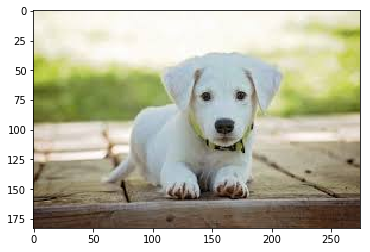

In [135]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

get_output("./images/ex1.jpg")

Woof woof!!! You might be a Alaskan_malamute


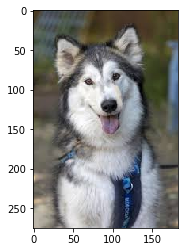

In [136]:
get_output("./images/ex2.jpg")

Hey there human, If you were a dog you probably would belong to Afghan_hound breed


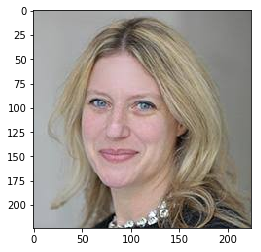

In [23]:
get_output("./images/ex3.jpg")

Hey there human, If you were a dog you probably would belong to Bullmastiff breed


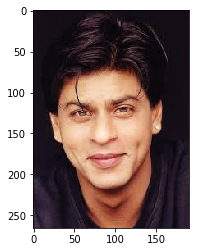

In [24]:
get_output("./images/ex4.jpg")

Hey there human, If you were a dog you probably would belong to Glen_of_imaal_terrier breed


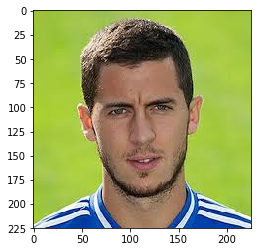

In [25]:
get_output("./images/ex5.jpg")

Woof woof!!! You might be a Wirehaired_pointing_griffon


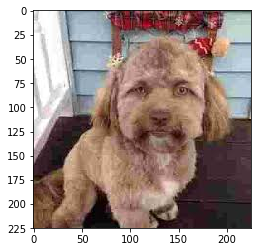

In [140]:
get_output("./images/ex6.jpg")

I'm not certain that the image is of a dog or human. Please use some other image.


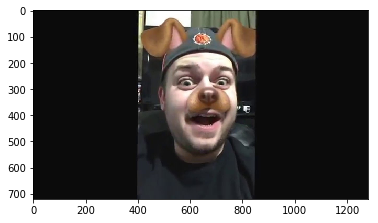

In [31]:
get_output("./images/ex7.jpg")

Hey there human, If you were a dog you probably would belong to American_staffordshire_terrier breed


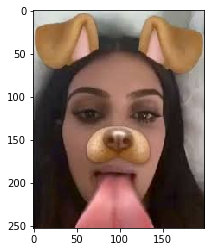

In [26]:
get_output("./images/ex8.jpg")

Woof woof!!! You might be a Brittany


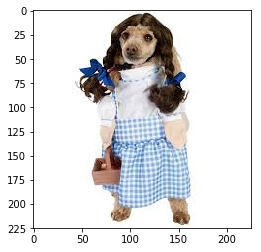

In [38]:
get_output("./images/ex9.jpg")

I'm not certain that the image is of a dog or human. Please use some other image.


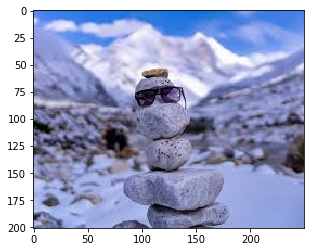

In [39]:
get_output("./images/ex10.jpg")